In [6]:
import pandas as pd
import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import nltk
nltk.download('punkt')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, SimpleRNN, Activation, Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.layers import Flatten
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import Orthogonal
from collections import defaultdict
from keras.models import load_model
from nltk.tokenize import sent_tokenize
from wordcloud import STOPWORDS


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Datasets

In [7]:
df = pd.read_csv('train_preprocess.tsv.txt', sep='\t', names=['text', 'label'], header=None)

In [3]:
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


In [4]:
df.shape

(5245, 2)

In [5]:
df.label.value_counts()

label
positive    3092
negative    1616
neutral      536
Name: count, dtype: int64

In [ ]:
df.describe()

,text,label
count,11000,11000
unique,10933,3
top,kesal,positive
freq,4,6416


In [8]:
df.drop_duplicates()
df.head()

,text,label
0,warung ini dimiliki oleh pengusaha pabrik tahu...,positive
1,mohon ulama lurus dan k212 mmbri hujjah partai...,neutral
2,lokasi strategis di jalan sumatera bandung . t...,positive
3,betapa bahagia nya diri ini saat unboxing pake...,positive
4,duh . jadi mahasiswa jangan sombong dong . kas...,negative


### Convert label into numeric

In [9]:
label2id = {"neutral":0, "positive":1, "negative":2}


for data in [df]:
    data["label"] = data["label"].map(label2id)

In [17]:
df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,1,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,1,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,2,aduh jadi mahasiswa jangan sombong dong kasih ...


## Text Normalization

In [ ]:
df['text'][0]

'warung ini dimiliki oleh pengusaha pabrik tahu yang sudah puluhan tahun terkenal membuat tahu putih di bandung . tahu berkualitas , dipadu keahlian memasak , dipadu kretivitas , jadilah warung yang menyajikan menu utama berbahan tahu , ditambah menu umum lain seperti ayam . semuanya selera indonesia . harga cukup terjangkau . jangan lewatkan tahu bletoka nya , tidak kalah dengan yang asli dari tegal !'

In [ ]:
len(df['text'][0].split(' '))

66

In [8]:
def count_word(text):
    list_of_text = text.split(' ')
    n_words = len(list_of_text)
    return n_words

df['text'].apply(count_word)

0       66
1       17
2       33
3       17
4       38
        ..
5240    33
5241    20
5242    38
5243    22
5244     1
Name: text, Length: 5245, dtype: int64

In [9]:
for data in [df]:
    data['word_count'] = data['text'].apply(count_word)

df.head()

,text,label,word_count
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1.0,66
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0.0,17
2,lokasi strategis di jalan sumatera bandung . t...,1.0,33
3,betapa bahagia nya diri ini saat unboxing pake...,1.0,17
4,duh . jadi mahasiswa jangan sombong dong . kas...,2.0,38


In [10]:
def clean_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-z0-9\s]','', text)
    text = re.sub('  +', ' ', text)
    return text


In [11]:
df_kamus_alay = pd.read_csv("new_kamusalay.csv", encoding= 'latin1', header=None)
kamus_alay_map = dict(zip(df_kamus_alay[0], df_kamus_alay[1]))
def alay_word(text):
    return ' '.join([kamus_alay_map[word] if word in kamus_alay_map else word for word in text.split(' ')])

In [12]:
def processed_text(text):
    text = clean_text(text)
    text = alay_word(text)
    return text

In [96]:
for data in [df]:
    data['text_clean'] = data['text'].apply(processed_text)

df.head()

,text,label,text_clean
0,warung ini dimiliki oleh pengusaha pabrik tahu...,1,warung ini dimiliki oleh pengusaha pabrik tahu...
1,mohon ulama lurus dan k212 mmbri hujjah partai...,0,mohon ulama lurus dan k212 mmbri hujjah partai...
2,lokasi strategis di jalan sumatera bandung . t...,1,lokasi strategis di jalan sumatra bandung temp...
3,betapa bahagia nya diri ini saat unboxing pake...,1,betapa bahagia nya diri ini saat unboxing pake...
4,duh . jadi mahasiswa jangan sombong dong . kas...,2,aduh jadi mahasiswa jangan sombong dong kasih ...


In [97]:
with open('text_clean.pickle', 'wb') as handle:
    pickle.dump(df['text_clean'].values, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("text_clean.pickle has created!")

text_clean.pickle has created!


## Tokenizer

In [14]:
max_features = 100000 # ada brp yg kita simpan
tokenizer = Tokenizer(num_words=max_features, split=' ', lower=True)
tokenizer.fit_on_texts(df['text_clean'].values)
with open('tokenizer.pickle', 'wb') as handle:
  pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("tokenizer.pickle has created!")
X = tokenizer.texts_to_sequences(df['text_clean'].values)

vocab_size = len(tokenizer.word_index)
max_len = max(len(x) for x in X)

X = pad_sequences(X, maxlen=max_len)
with open('x_pad_sequence.pickle', 'wb') as handle:
  pickle.dump(X, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("x_pad_sequence.pickle has created!")

tokenizer.pickle has created!
x_pad_sequence.pickle has created!


In [15]:
X

array([[   0,    0,    0, ...,  462,   19, 2163],
       [   0,    0,    0, ...,  210,    5, 8592],
       [   0,    0,    0, ...,    1,   14,  470],
       ...,
       [   0,    0,    0, ...,    2,  707, 4831],
       [   0,    0,    0, ..., 2933,   31,   11],
       [   0,    0,    0, ...,   13,    1,   31]], dtype=int32)

## Feature Extraction

In [ ]:
# # Bag of Words
# bow = CountVectorizer()
# bow.fit(df['text_clean'])
# X = bow.transform(df['text_clean'])

In [ ]:
# # TF-IDF
# tfidf = TfidfVectorizer()
# tfidf.fit(df['text_clean'])
# X = tfidf.transform(df['text_clean']).toarray()

## Train & Test Dataset

In [16]:
Y = pd.get_dummies(df['label']).values
with open('y_labels.pickle', 'wb') as handle:
  pickle.dump(Y, handle, protocol=pickle.HIGHEST_PROTOCOL)
  print("y_labels.pickle has created!")
Y

y_labels.pickle has created!


array([[False,  True, False],
       [ True, False, False],
       [False,  True, False],
       ...,
       [ True, False, False],
       [False, False,  True],
       [False,  True, False]])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 123)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(8250, 91) (2750, 91)
(8250, 3) (2750, 3)


In [23]:
X_train.shape[1]

91

## StandardScaler

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [80]:
embed_dim = 100
units_1 = 64
units_2 = 32

model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=max_features, output_dim=embed_dim, input_length=X_train.shape[1]))
model_lstm.add(LSTM(units_1, dropout=0.5, return_sequences=True))
model_lstm.add(LSTM(units_2, dropout=0.5))
model_lstm.add(Dense(3, activation='softmax'))

loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=30, restore_best_weights=True)

# sgd = tf.keras.optimizers.SGD(learning_rate=0.001)
adam = tf.keras.optimizers.Adam(learning_rate=0.0001)
model_lstm.compile(optimizer=adam,
             loss=loss_fn,
             metrics=['accuracy'])

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
model_lstm.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_18 (Embedding)    (None, 91, 100)           10000000  
                                                                 
 lstm_34 (LSTM)              (None, 91, 64)            42240     
                                                                 
 lstm_35 (LSTM)              (None, 32)                12416     
                                                                 
 dense_17 (Dense)            (None, 3)                 99        
                                                                 
Total params: 10054755 (38.36 MB)
Trainable params: 10054755 (38.36 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [81]:
epoch = 30
history = model_lstm.fit(X_train, y_train, epochs=epoch, validation_data=(X_test, y_test), callbacks=[es], verbose=2, batch_size=30)

Epoch 1/30
275/275 - 22s - loss: 0.8288 - accuracy: 0.6292 - val_loss: 0.6426 - val_accuracy: 0.7349 - 22s/epoch - 81ms/step
Epoch 2/30
275/275 - 5s - loss: 0.6078 - accuracy: 0.7475 - val_loss: 0.5383 - val_accuracy: 0.7833 - 5s/epoch - 19ms/step
Epoch 3/30
275/275 - 7s - loss: 0.5246 - accuracy: 0.7735 - val_loss: 0.4880 - val_accuracy: 0.7927 - 7s/epoch - 25ms/step
Epoch 4/30
275/275 - 4s - loss: 0.4539 - accuracy: 0.8012 - val_loss: 0.4501 - val_accuracy: 0.8080 - 4s/epoch - 16ms/step
Epoch 5/30
275/275 - 4s - loss: 0.3954 - accuracy: 0.8410 - val_loss: 0.4195 - val_accuracy: 0.8367 - 4s/epoch - 15ms/step
Epoch 6/30
275/275 - 6s - loss: 0.3386 - accuracy: 0.8737 - val_loss: 0.4071 - val_accuracy: 0.8404 - 6s/epoch - 20ms/step
Epoch 7/30
275/275 - 4s - loss: 0.2876 - accuracy: 0.8982 - val_loss: 0.4059 - val_accuracy: 0.8411 - 4s/epoch - 14ms/step
Epoch 8/30
275/275 - 4s - loss: 0.2589 - accuracy: 0.9073 - val_loss: 0.3825 - val_accuracy: 0.8538 - 4s/epoch - 13ms/step
Epoch 9/30
275

### Evaluasi

In [26]:
score = model_lstm.evaluate(X_test, y_test, verbose=2)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

86/86 - 1s - loss: 0.5568 - accuracy: 0.8615 - 510ms/epoch - 6ms/step
Test Score: 0.5567576289176941
Test Accuracy: 0.8614545464515686


In [84]:
predictions = model_lstm.predict(X_test)
y_pred = predictions
matrix_test = metrics.classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1))
print("Testing selesai")
print(matrix_test)

86/86 [==============================] - 1s 5ms/step
Testing selesai
              precision    recall  f1-score   support

           0       0.79      0.69      0.74       272
           1       0.93      0.90      0.92      1624
           2       0.78      0.86      0.82       854

    accuracy                           0.87      2750
   macro avg       0.83      0.82      0.82      2750
weighted avg       0.87      0.87      0.87      2750



### Predict dan kalkulasi

In [ ]:
# y_pred = model_lstm.predict(X_test)
# y_pred_classes = np.argmax(y_pred, axis=1)
# y_true = np.argmax(y_test, axis=1)
# print("Accuracy Score:", accuracy_score(y_true, y_pred_classes))

### Plot 'Accuracy'


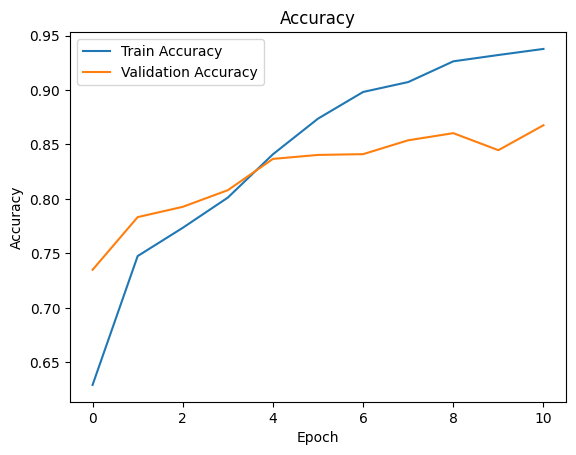

In [82]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Plot 'Loss'

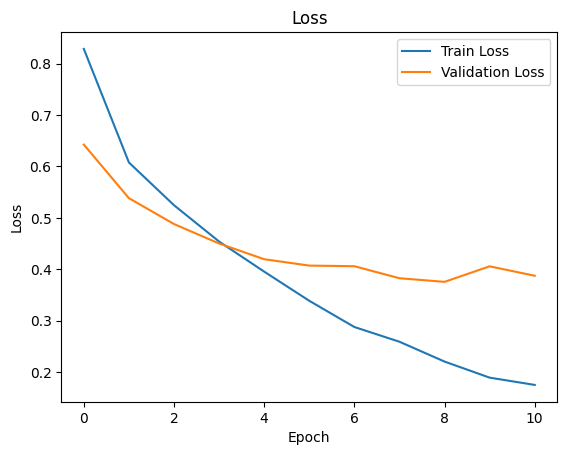

In [83]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [101]:
model_lstm.save('model_lstm.h5')
print("Model has created!")

Model has created!


In [ ]:
# with open('lstm.pickle', 'wb') as handle:
#   pickle.dump(model_lstm, handle, protocol=pickle.HIGHEST_PROTOCOL)
#   print("lstm.pickle has created!")

lstm.pickle has created!


## Cross Validation

In [ ]:
kf = KFold(n_splits=5, random_state=42, shuffle=True)

scores = []
fold = []

for idx, (train_idx, test_idx) in enumerate(kf.split(X), start=1):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = Y[train_idx], Y[test_idx]

    knn_k = KNeighborsClassifier(n_neighbors=13, metric='l2')
    knn_k.fit(X_train, y_train)
    y_pred = knn_k.predict(X_test)
    score = accuracy_score(y_test, y_pred)
    scores.append(score)
    fold.append(idx)

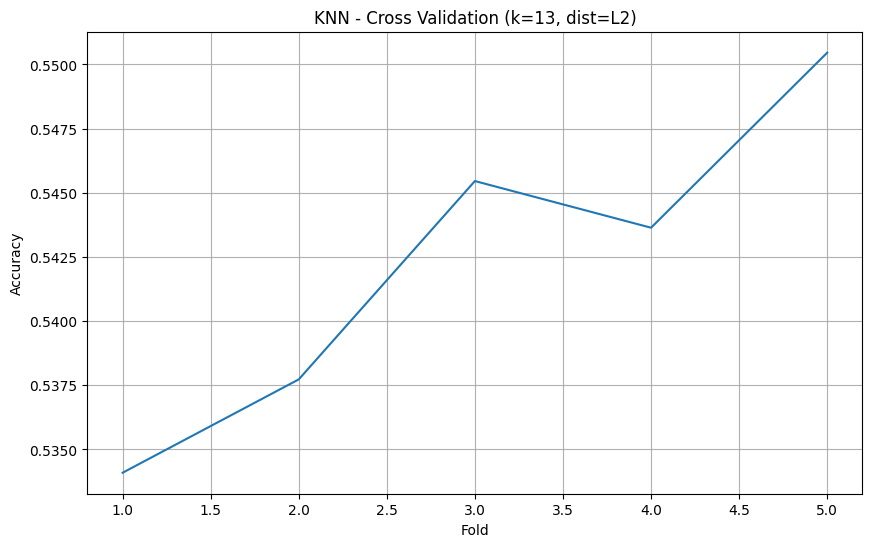

In [ ]:
plt.figure(figsize=(10,6))
plt.title("KNN - Cross Validation (k=13, dist=L2)")
plt.plot(fold, scores)
plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.grid()
plt.show()

## Predict PPT BINAR

In [98]:
input_text = """
bersyukur
"""

def cleansing(sent):
  string = sent.lower()
  string = re.sub(r'[^a-zA-Z0-9]', ' ', string)
  return string

In [100]:
sentiment = {0: 'neutral', 1: 'positive', 2: 'negative'}

text = [cleansing(input_text)]
print(type(text))
file_lstm = open("tokenizer.pickle", 'rb')
tokenizer_lstm = pickle.load(file_lstm)
predicted = tokenizer_lstm.texts_to_sequences(text)
guess = pad_sequences(predicted, maxlen=max_len) #X.shape[1]

# file_lstm = open('lstm.pickle','rb')
model = load_model('model_lstm.h5')
prediction = model.predict(guess)
print("Raw Predictions:", prediction)
polarity = np.argmax(prediction[0])

print("Text: ",polarity)
print("Sentiment: ",sentiment[polarity])

<class 'list'>
1/1 [==============================] - 1s 1s/step
Raw Predictions: [[0.18617389 0.43569207 0.37813404]]
Text:  1
Sentiment:  positive


In [ ]:
polarity = np.argmax(prediction[0])

# if polarity == 0:
#   sentimen_label = "neutral"
# elif polarity == 1:
#   sentiment_label = "positive"
# elif polarity == 2:
#   sentiment_label = "negative"

sentiment_label = sentiment[polarity]

print("Text: ",text[0])
print("Sentiment: ", sentiment_label)

Text:   fuck  
Sentiment:  negative


In [ ]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=['neutral', 'positive', 'negative']))

69/69 [==============================] - 2s 25ms/step
              precision    recall  f1-score   support

     neutral       0.82      0.78      0.80       245
    positive       0.92      0.91      0.91      1285
    negative       0.79      0.83      0.81       670

    accuracy                           0.87      2200
   macro avg       0.84      0.84      0.84      2200
weighted avg       0.87      0.87      0.87      2200



In [ ]:
# threshold = 0.5  # Example threshold value
# polarity = np.argmax(prediction[0])

# # Check if prediction meets threshold for negative sentiment
# if prediction[0][1] > threshold:  # Assuming 1 corresponds to 'positive'
#     print("Text: ", text[0])
#     print("Sentiment: positive")
# elif prediction[0][2] > threshold:  # Assuming 2 corresponds to 'negative'
#     print("Text: ", text[0])
#     print("Sentiment: negative")
# else:
#     print("Text: ", text[0])
#     print("Sentiment: ", sentiment[polarity])

In [ ]:
# evaluation = model.evaluate(X_test, y_test)
# print("Evaluation Loss:", evaluation[0])
# print("Evaluation Accuracy:", evaluation[1])